In [1]:
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from torch_geometric.nn.conv import DynamicEdgeConv
from torch_geometric.nn.pool import avg_pool_x

Ok First lets load the data. We will make an even split between signal and background. 

In [2]:
class DataSet(Dataset):
    def __init__(self, samples, labels):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        return x, y

def load(filename):
    h5file = h5py.File(filename, 'r') # open read-only
    mass=h5file.get('jet1_m').astype("float32")
    pt=h5file.get('jet1_pt').astype("float32")
    t21=h5file.get('jet1_tau21').astype("float32")
    t32=h5file.get('jet1_tau32').astype("float32")
    total=torch.from_numpy(np.vstack((mass[:],pt[:],t21[:],t32[:])))
    total=total.T
    return total

#note the particles need to be transformed
def load_parts(filename):
    h5file = h5py.File(filename, 'r') # open read-only
    ce=h5file.get('ce').astype("float32")
    cpx=h5file.get('cpx').astype("float32")
    cpy=h5file.get('cpy').astype("float32")
    cpz=h5file.get('cpz').astype("float32")
    ce =np.reshape(ce, (len(ce), 1,200))
    cpx=np.reshape(cpx,(len(cpx),1,200))
    cpy=np.reshape(cpy,(len(cpy),1,200))
    cpz=np.reshape(cpz,(len(cpz),1,200))
    total=torch.from_numpy(np.hstack((ce,cpx,cpy,cpz)))
    total=np.swapaxes(total,1,2)
    return total

#Basic test (if you want to do this uncomment and comment load_parts)
#also comment Dyanmic_Edge bit and uncomment simple_model bit in contr_model
#sigtot=load('sig_particleNet_sample.h5')
#bkgtot=load('bkg_particleNet_sample.h5')

sigtot=load_parts('sig_particleNet_sample.h5')
bkgtot=load_parts('bkg_particleNet_sample.h5')
siglabel=torch.ones(len(sigtot))
bkglabel=torch.zeros(len(bkgtot))
print(len(sigtot),len(bkgtot))
#data_sig=DataSet(samples=sigtot,labels=siglabel)
#data_bkg=DataSet(samples=bkgtot,labels=bkglabel)
tot=torch.cat((sigtot,bkgtot[0:50000]))
tot=(tot - tot.mean(axis=0))/tot.std(axis=0)
label=torch.cat((siglabel,bkglabel[0:50000]))
data=DataSet(samples=tot,labels=label)


torch.Size([50000, 200, 4])
torch.Size([100000, 200, 4])
50000 100000


Now we need a sampler that samples both signals and backgrounds in an even way so we can pair them up in augmentation space. 

In [3]:
class DelphesSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        self.dataset_length = len(dataset)/2
        self.n_batches = self.dataset_length / self.batch_size
        self.batch_ids = torch.randperm(int(self.n_batches))

    def __len__(self):
        return self.batch_size

    def __iter__(self):
        for id in self.batch_ids:
            idx1 = torch.arange(id * self.batch_size, (id + 1) * self.batch_size)
            idx2 = torch.arange(id * self.batch_size, (id + 1) * self.batch_size)+self.dataset_length
            for index in np.append(idx1,idx2):
                yield int(index)
        if int(self.n_batches) < self.n_batches:
            idx1 = torch.arange(int(self.n_batches) * self.batch_size, self.dataset_length)
            idx2 = torch.arange(int(self.n_batches) * self.batch_size, self.dataset_length)+self.dataset_length
            for index in np.append(idx1,idx2):
                yield int(index)

Now pick my favorite contrastive loss VICReg.

In [4]:
class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20,sort_tolerance=1.0,sort_reg='l2'):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        self.tolerance = sort_tolerance
        self.reg       = sort_reg

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        N = x.size(0)
        D = x.size(1)
         
        var_x = torch.sqrt(x.var(dim=0) + 0.0001)
        var_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss  = torch.mean(F.relu(1 - var_x)) / 2 + torch.mean(F.relu(1 - var_y)) / 2

        x = (x-x.mean(dim=0))/x.std(dim=0)
        y = (y-y.mean(dim=0))/y.std(dim=0)

        cov_x = (x.T @ x) / (N - 1)
        cov_y = (y.T @ y) / (N - 1)
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D) + self.off_diagonal(cov_y).pow_(2).sum().div(D)
        return repr_loss,cov_loss,std_loss


    def off_diagonal(self,x):
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()



Now a bunch of generic models that we will use for our setup

In [5]:
class simple_MLP(torch.nn.Module):
    def __init__(self,input_size,out_channels=1,act_out=False,nhidden=50,batchnorm=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden, bias=False),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels)
            #nn.Sigmoid()
        )
        #extra layer for vicreg
        self.vicreg = nn.Sequential(
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        self.runbatchnorm = batchnorm
        self.batchnorm    = torch.nn.BatchNorm1d(out_channels)
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out 

    def forward(self, x):
        x = self.model(x)        
        if self.runbatchnorm:
            x = self.batchnorm(x)
        if self.act_out:
            x = self.output(x)
        return x

    def forward_vicreg(self, x):
        out = self.forward(x) 
        out = self.vicreg(out) #Vicreg adds a layer for training
        return out

class simple_MLP_onelayer(torch.nn.Module):
    def __init__(self,input_size,out_channels=1,act_out=False,nhidden=64,batchnorm=False):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.output  = torch.nn.Sigmoid()
        self.act_out = act_out 

    def forward(self, x):
        x = self.model(x)        
        if self.act_out:
            x = self.output(x)
        return x

Now lets do a simple particle-net model, aka a DGCNN

In [35]:
class simple_Edge(torch.nn.Module):
    def __init__(self,input_size,out_channels=1,act_out=False,nhidden=64,batchnorm=False):#512
        super().__init__()
        
        self.input_feat = input_size
        self.part_encode = nn.Sequential(
            nn.Linear(input_size, nhidden, bias=False),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            nn.ELU(),
            nn.Linear(nhidden, nhidden),
            #nn.ELU(),
            #nn.Linear(nhidden, nhidden),
            #nn.ELU()
            #nn.Linear(nhidden, out_channels)
            #nn.Sigmoid()
        )
        #self.part_encode.cuda()
        self.conv = DynamicEdgeConv(nn=nn.Sequential(nn.Linear(2*nhidden, nhidden), nn.ELU()),k=12, aggr = 'add')
        #self.conv.cuda()
        self.output = nn.Sequential(
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden//2),
            nn.ReLU(),
            nn.Linear(nhidden//2, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
        )
        self.vicreg = nn.Sequential(
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        #self.output.cuda()
        #self.vicreg.cuda()
        self.runbatchnorm = batchnorm
        self.batchnorm    = torch.nn.BatchNorm1d(out_channels)
        self.output_act  = torch.nn.Sigmoid()
        self.act_out = act_out 

    def forward(self, x):
        #parts=(x.shape[1])//self.input_feat
        #print(x.shape,parts)
        parts=x.shape[1]
        x_batch = torch.arange(0,x.shape[0])
        x_batch = x_batch.repeat_interleave(parts)
        #x_batch = x_batch.cuda()
        x_part     = x.reshape((parts*x.shape[0],self.input_feat))
        x_part_enc = self.part_encode(x_part)
        #feats1     = self.conv(x=x_part_enc)#, batch=batch_part)
        feats1     = self.conv(x=(x_part_enc,x_part_enc), batch=(x_batch,x_batch))
        batch      = x_batch
        out, batch = avg_pool_x(batch, feats1, batch)
        out = self.output(out)
        if self.runbatchnorm:
            out = self.batchnorm(out)
        if self.act_out:
            out = self.output_act(out)
        return out

    def forward_vicreg(self, x):
        out = self.forward(x)
        out = self.vicreg(out)
        return out

Now we are going to make a contrastive object that does both a contrastive training (model1) and supervised on the space (model2) and a base training (model2_base). 

In [50]:
class contr_model():
    def __init__(self,dataset,inspace=2,batch_size=250,n_epochs=3,n_epochs_mse=3):
        super().__init__()
        #self.model1      = simple_MLP(data.samples.shape[1],inspace)
        #self.model2_base = simple_MLP(data.samples.shape[1],out_channels=1,act_out=True,batchnorm=True)
        #self.model2      = simple_MLP_onelayer(inspace,out_channels=1,act_out=True,batchnorm=True)
        self.model1      = simple_Edge(data.samples.shape[2],inspace,act_out=False)
        self.model2      = simple_MLP(inspace,out_channels=1,act_out=True,batchnorm=True)
        self.model2_base = simple_Edge(data.samples.shape[2],out_channels=1,act_out=True,batchnorm=True)
        outspace = inspace
        #self.model1.cuda(); self.model2.cuda(); self.model2_base.cuda()
        self.ctr_loss   = VICRegLoss(lambda_param=1.0,mu_param=1.0,nu_param=1.0)
        #self.ctr_loss   = SimCLRLoss(batch_size=batch_size)
        #self.mse_loss   = nn.MSELoss()
        self.mse_loss   = nn.BCELoss()
        self.batch_size = batch_size
        self.n_epochs     = n_epochs
        self.n_epochs_mse = n_epochs_mse
        self.opt1       = torch.optim.Adam(self.model1.parameters(),lr=0.005)
        self.opt2       = torch.optim.Adam(self.model2.parameters(),lr=0.00005)
        self.opt_base   = torch.optim.Adam(self.model2_base.parameters(),lr=0.005)
        self.dataset    = dataset
        self.train,self.test = self.split(dataset,0.8)
    
    def split(self,iDataset,iFrac):
        randind         = torch.randperm(len(iDataset)//2)
        randtrain       = randind[                      0:int(iFrac*len(randind))]
        randtest        = randind[int(iFrac*len(randind)):          len(randind)]
        randtrain       = torch.cat((randtrain,(randtrain+len(randind))))
        randtest        = torch.cat((randtest ,(randtest +len(randind))))
        train           = Subset(iDataset,randtrain)
        test            = Subset(iDataset,randtest)
        return train,test

    def save(self,header=''):
        torch.save(self.model1.state_dict(),header+'_encodor.pt')
        torch.save(self.model2.state_dict(),header+'_decoder.pt')
        torch.save(self.model2_base.state_dict(),header+'_base.pt')

    def load(self,header=''):
        self.model1.load_state_dict(torch.load(header+'_encodor.pt'))
        self.model2.load_state_dict(torch.load(header+'_decoder.pt'))
        self.model2_base.load_state_dict(torch.load(header+'_base.pt'))
            
    def forward(self, x):
        x = self.model1(x)        
        return x
        
    def training_loss(self, x1, x2):
        x1_hat = self.model1.forward_vicreg(x1)
        x2_hat = self.model1.forward_vicreg(x2)
        loss_clr,loss_corr,loss_var = self.ctr_loss(x1_hat,x2_hat)
        return loss_clr+loss_corr+loss_var
    
    def training_clr_epoch(self):
        running_loss = 0.0; running_loss_clr = 0.0;
        train_loader1 = self.train_dataloader()
        x1=None; 
        updates=1
        for batch_idx, (x, _)  in enumerate(train_loader1):
            #x=x.to('cuda');
            self.opt1.zero_grad()
            x2 = x[0]
            #x2 = torch.reshape(x,((x.shape[1],x.shape[2])))
            if (batch_idx+1) % 2 == 0:
                if len(x1) == len(x2):
                    loss = self.training_loss(x1,x2)
                    loss.backward()
                    self.opt1.step()
                    running_loss += loss
                updates = updates + 1
            else:
                x1=x2.clone().detach()
            del x
        return running_loss/updates

    def validate_clr_epoch(self):
        running_loss = 0.0
        val_loader1 = self.val_dataloader()
        x1=None
        updates=1
        batch_idx=0
        for batch_idx,(x, _ )  in enumerate(val_loader1):
            #x=x.to('cuda');
            #self.opt1.zero_grad()
            x2 = x[0]
            #x2 = torch.reshape(x,((x.shape[1],x.shape[2])))
            if (batch_idx + 1) % 2 == 0:
                if len(x1) == len(x2):
                    with torch.no_grad():
                        loss = self.training_loss(x1,x2)
                        running_loss += loss 
                updates = updates + 1
            else:
                x1=x2.clone().detach()
            del x
        return running_loss/updates

    def training_mse_epoch(self,imodel,iloader, iopt):
        running_loss = 0.0
        train_loader = iloader
        updates=0
        for batch_idx, (x, y) in enumerate(train_loader):
            iopt.zero_grad()
            #x     = x.cuda(); y = y.cuda()
            x_out = imodel(x)
            loss  = self.mse_loss(x_out.flatten(), y.flatten())
            loss.backward()
            iopt.step()
            running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def validate_mse_epoch(self,imodel,iloader):
        running_loss = 0.0
        val_loader   = iloader
        updates=0
        for batch_idx, (x, y)   in enumerate(val_loader):
            #x     = x.cuda(); y = y.cuda()
            with torch.no_grad():
                x_out = imodel(x)
                #print(x_out.shape,y.shape)
                loss  = self.mse_loss(x_out.flatten(), y.flatten())
                running_loss += loss 
            updates = updates+1
        return running_loss/updates

    def test_all(self):
        test_loader   = self.test_dataloader()
        scores_out    = np.array([])
        labels_out    = np.array([])
        space_out     = np.array([])
        for batch_idx, (x, y)   in enumerate(test_loader):
            #x = torch.reshape(x,((x.shape[1],x.shape[2])))
            #x = x.to('cuda') 
            x1_out = self.model1(x) 
            #x1_out     = x1_out[:,np.r_[self.coords]] ## => projecting out dimensions
            x2_out = self.model2(x1_out) 
            scores_out = np.append(scores_out,x2_out.cpu().detach().numpy())
            labels_out = np.append(labels_out,y)
            space_out  = np.append(space_out,x1_out.cpu().detach().numpy())
        return scores_out,labels_out,space_out
    
    def test_base(self):
        test_loader   = self.test_dataloader()
        scores_out = np.array([])
        labels_out = np.array([])
        space_out  = np.array([])
        for batch_idx, (x, y)   in enumerate(test_loader):
            #x = x.to('cuda') 
            x_out = self.model2_base(x) 
            scores_out = np.append(scores_out,x_out.cpu().detach().numpy())
            labels_out = np.append(labels_out,y)
            space_out  = np.append(space_out,x_out.cpu().detach().numpy())
        return scores_out,labels_out,space_out
    
    def training_clr(self):
        print("Training")
        for epoch in range(self.n_epochs):
            self.model1.train(True)
            loss_train= self.training_clr_epoch()
            self.model1.train(False)
            loss_valid = self.validate_clr_epoch()
            print('Epoch: {} LOSS train: {:.4f} valid: {:.4f}'.format(epoch,loss_train,loss_valid))
            self.save()
    
    def training_mse(self):
        for epoch in range(self.n_epochs_mse):
            self.model2.train(True)
            loss_train = self.training_mse_epoch(self.model2,self.train_dataloader_mse(),self.opt2)
            self.model2.train(False)
            loss_valid = self.validate_mse_epoch(self.model2,self.val_dataloader_mse())
            print('Epoch: {} LOSS train: {} valid: {}'.format(epoch,loss_train,loss_valid))

    def training_base_mse(self):
        for epoch in range(self.n_epochs_mse):
            self.model2_base.train(True)
            loss_train = self.training_mse_epoch(self.model2_base,self.train_dataloader_base_mse(),self.opt_base)
            self.model2_base.train(False)
            loss_valid = self.validate_mse_epoch(self.model2_base,self.val_dataloader_base_mse())
            print('Epoch: {} LOSS train: {} valid: {}'.format(epoch,loss_train,loss_valid))

    def setup(self, stage=None):
        self.ttrain,self.tval  = self.split(self.train,0.8)

    def setup_mse(self,stage=None):
        train_loader = self.fulltrain_dataloader()
        with torch.no_grad():
            train_mse_out   = np.array([])
            train_label_out = np.array([])
            for batch_idx, (x, y)   in enumerate(train_loader):
                #x = x.cuda()
                #x = torch.reshape(x,((x.shape[1],x.shape[2])))
                train_mse_out_tmp = self.model1(x)
                train_mse_out   = np.append(train_mse_out,train_mse_out_tmp.cpu().numpy().astype('float32'))
                train_label_out = np.append(train_label_out,y)
            train_mse_out     = np.reshape(train_mse_out,(len(train_label_out),int(len(train_mse_out)/len(train_label_out))))
            #train_mse_out     = train_mse_out[:,np.r_[self.coords]]       
            train_label_out   = np.reshape(train_label_out,(len(train_label_out),1))
            #randind           = torch.randperm(len(train_mse_out))
            train_mse_out     = train_mse_out.astype('float32')
            train_label_out   = train_label_out.astype('float32')
            train_mse         = DataSet(samples=train_mse_out,labels=train_label_out)
            ntot              = len(train_mse)
            self.data_train_mse, self.val_train_mse = random_split(train_mse, [int(0.8*ntot),ntot-int(0.8*ntot)])

    def fulltrain_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size,pin_memory=True)

    def train_dataloader(self):
        return DataLoader(self.ttrain, batch_size=1,sampler=BatchSampler(DelphesSampler(self.ttrain,batch_size=self.batch_size),batch_size=2*self.batch_size,drop_last=False),pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.tval, batch_size=1,sampler=BatchSampler(DelphesSampler(self.tval,batch_size=self.batch_size),batch_size=2*self.batch_size,drop_last=False),pin_memory=True)

    def train_dataloader_mse(self):
        return DataLoader(self.data_train_mse, batch_size=self.batch_size,shuffle=True,pin_memory=True)

    def train_dataloader_base_mse(self):
        return DataLoader(self.ttrain, batch_size=self.batch_size,shuffle=True)

    def val_dataloader_mse(self):
        return DataLoader(self.val_train_mse, batch_size=self.batch_size,shuffle=True,pin_memory=True)

    def val_dataloader_base_mse(self):
        return DataLoader(self.tval, batch_size=self.batch_size,shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size,shuffle=True,pin_memory=True)

    def run_all(self):
        self.setup()
        self.training_clr()
        #torch.cuda.empty_cache()
        self.setup_mse()
        self.training_mse()
        scores_out,labels_out,space_out = self.test_all()
        #mask = (mass_out > -70) & (mass_out < 900)
        auc = roc_auc_score(y_score=scores_out, y_true=labels_out)
        print("AUC",auc)
        return scores_out,labels_out,space_out

    def run_base(self):
        self.setup()
        #self.setup_mse()
        self.training_base_mse()
        scores_out,labels_out,space_out = self.test_base()
        #mask = (mass_out > -70) & (mass_out < 900)
        auc = roc_auc_score(y_score=scores_out, y_true=labels_out)
        print("AUC",auc)
        return scores_out,labels_out,space_out

Now lets run everything

In [51]:
#print(data.samples.shape)
ctr_model=contr_model(data,inspace=8)#8 dimensional Contrastive Space
scores_base,labels_base,space_base=ctr_model.run_base()

Epoch: 0 LOSS train: 0.6931807398796082 valid: 1.0855096578598022
Epoch: 1 LOSS train: 0.6932010054588318 valid: 1.4712456464767456
Epoch: 2 LOSS train: 0.6931895613670349 valid: 1.4250532388687134
AUC 0.5


In [52]:
scores_ctr,labels_ctr,space_ctr=ctr_model.run_all()

Training
Epoch: 0 LOSS train: 4.2012 valid: 2.5611
Epoch: 1 LOSS train: 1.8330 valid: 1.4599
Epoch: 2 LOSS train: 1.2969 valid: 1.1756
Epoch: 0 LOSS train: 0.71220463514328 valid: 0.6963523030281067
Epoch: 1 LOSS train: 0.685274064540863 valid: 0.6841124296188354
Epoch: 2 LOSS train: 0.6806195974349976 valid: 0.6812255382537842
AUC 0.582115945


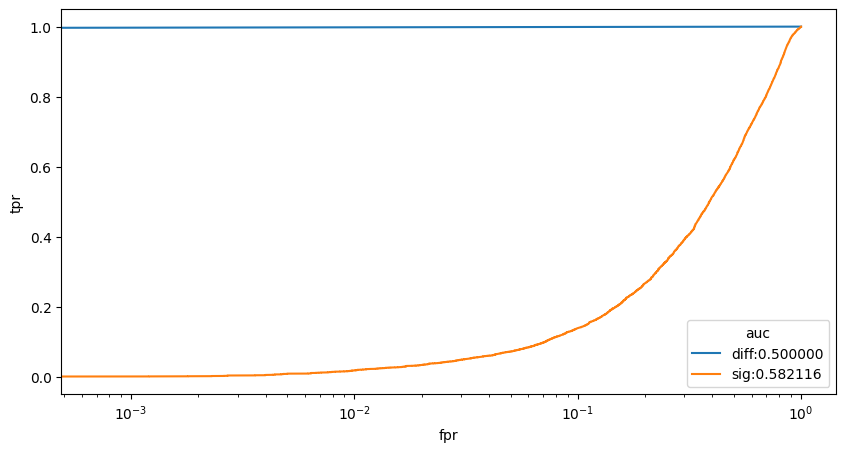

In [53]:
from matplotlib import pyplot as plt

def rocplot(iV,iLabel):
    auc_value                  = roc_auc_score(y_score=iV, y_true=iLabel)
    fpr_value, tpr_value, cuts = roc_curve    (y_score=iV, y_true=iLabel)
    if auc_value < 0.5:
        auc_value                  = roc_auc_score(y_score=iV, y_true=(1-iLabel))
        fpr_value, tpr_value, cuts = roc_curve    (y_score=iV, y_true=(1-iLabel))
    return fpr_value,tpr_value,auc_value

def plotROCs(scores_out0,labels_out0,scores_out1,labels_out1):
    figure, axis = plt.subplots(1, 1,figsize=(10,5))
    fprt,tprt,auct=rocplot(scores_out0,labels_out0)
    fpr1,tpr1,auc1=rocplot(scores_out1,labels_out1)
    #fpr2,tpr2,auc2=rocplot(scores_out2,labels_out)
    axis.plot(fprt, tprt,label="diff:{:.6f}".format(auct))
    axis.plot(fpr1, tpr1,label="sig:{:.6f}".format(auc1))
    #axis.plot(fpr2, tpr2,label="bkg:{:.6f}".format(auc2))
    axis.set_xscale('log')
    axis.set_xlabel("fpr")
    axis.set_ylabel("tpr")
    axis.legend(title="auc")
    plt.show()
    
plotROCs(scores_base,labels_base,scores_ctr,labels_ctr)

Now lets plot the contrastive space

In [ ]:
import corner

space_ctr=np.reshape(space_ctr,(space_ctr.shape[0]//8,8))
print(space_ctr.shape)
arrs=[r"$x$",r"$y$"]
figure = corner.corner(space_ctr[labels_ctr==0],quantiles=[0.16, 0.5, 0.84],show_titles=True,title_kwargs={"fontsize": 12},color='green')
corner.corner(space_ctr[labels_ctr==1], fig=figure,color='orange')
plt.show()


(20000, 8)
